In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import shutil
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import PIL
from PIL import Image, ImageOps 

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

c:\Users\neeraj.saini\AppData\Local\anaconda3\envs\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
#parameters
working_dir = r"C:\Users\neeraj.saini\Desktop\New folder\DeepD"
os.chdir(working_dir)
img_size = (128, 128) #size of image fed into model

In [48]:
# function to resize image
def resize_image(src_image, size=(128,128), bg_color="white"): 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, PIL.Image.Resampling.LANCZOS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

In [11]:
training_folder_name = r"C:\Users\neeraj.saini\Desktop\New folder\DeepD\shapes"

# New location for the resized images
train_folder = '../working/data/natural_images'


# Create the output folder if it doesn't already exist
if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

# Loop through each subfolder in the input folder
print('Transforming images...')
for root, folders, files in os.walk(training_folder_name):
    for sub_folder in folders:
        print('processing folder ' + sub_folder)
        # Create a matching subfolder in the output dir
        saveFolder = os.path.join(train_folder,sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        # Loop through the files in the subfolder
        file_names = os.listdir(os.path.join(root,sub_folder))
        for file_name in file_names:
            # Open the file
            file_path = os.path.join(root,sub_folder, file_name)
            #print("reading " + file_path)
            image = Image.open(file_path)
            # Create a resized version and save it
            resized_image = resize_image(image, img_size)
            saveAs = os.path.join(saveFolder, file_name)
            #print("writing " + saveAs)
            resized_image.save(saveAs)

Transforming images...
processing folder square
processing folder triangle


In [5]:
def load_dataset(data_path):
    # Load all the images
    transformation = transforms.Compose([
        # Randomly augment the image data
            # Random horizontal flip
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    
    # use torch.utils.data.random_split for training/test split
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=50,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader

In [6]:
# Recall that we have resized the images and saved them into
train_folder = '../working/data/natural_images'

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)
batch_size = train_loader.batch_size
print("Data loaders ready to read", train_folder)

Data loaders ready to read ../working/data/natural_images


In [11]:
training_folder_name = r"C:\Users\neeraj.saini\Desktop\New folder\Data\shapes"
classes = sorted(os.listdir(training_folder_name))
classes

['square', 'triangle']

In [12]:
# Create a neural net class
class Net(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=2):
        super(Net, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3. 
        # We will apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 12 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # We in the end apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # This means that our feature tensors are now 32 x 32, and we've generated 24 of them
        
        # We need to flatten these in order to feed them to a fully-connected layer
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        # Use a ReLU activation function after layer 1 (convolution 1 and pool)
        x = F.relu(self.pool(self.conv1(x))) 
        
        # Use a ReLU activation function after layer 2
        x = F.relu(self.pool(self.conv2(x)))  
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return torch.log_softmax(x, dim=1)
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

In [17]:
loss_criteria = nn.CrossEntropyLoss()

In [44]:
#train_data[0][0].shape ########################################----------torch.Size([3, 128, 128])

torch.Size([3, 128, 128])

In [28]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        # print(data.shape)
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        # print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
    print('train loss:{:.6f}'.format(train_loss))        
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [20]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    loss_criteria = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            # print(data.shape)
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

Training on cpu
Epoch: 1
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50, 3, 128, 128])
torch.Size([50,

In [23]:
# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Specify the loss criteria
# loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 10 epochs (We restrict to 10 for time issues)
epochs = 10
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
train loss:19.704153
Training set: Average loss: 0.187659
Validation set: Average loss: 0.001161, Accuracy: 2245/2246 (100%)

Epoch: 2
train loss:1.791833
Training set: Average loss: 0.017065
Validation set: Average loss: 0.002591, Accuracy: 2245/2246 (100%)

Epoch: 3
train loss:1.206416
Training set: Average loss: 0.011490
Validation set: Average loss: 0.000711, Accuracy: 2245/2246 (100%)

Epoch: 4
train loss:0.436264
Training set: Average loss: 0.004155
Validation set: Average loss: 0.000104, Accuracy: 2246/2246 (100%)

Epoch: 5
train loss:0.553444
Training set: Average loss: 0.005271
Validation set: Average loss: 0.000006, Accuracy: 2246/2246 (100%)

Epoch: 6
train loss:0.982023
Training set: Average loss: 0.009353
Validation set: Average loss: 0.000001, Accuracy: 2246/2246 (100%)

Epoch: 7
train loss:0.497322
Training set: Average loss: 0.004736
Validation set: Average loss: 0.000001, Accuracy: 2246/2246 (100%)

Epoch: 8
train loss:0.187783
Training set: Av

In [24]:
path = r"C:\Users\neeraj.saini\Desktop\New folder\DeepD\model_square_tri.h5"
torch.save(model, path)

In [25]:
# path = r"C:\Users\neeraj.saini\Desktop\New folder\DeepD\model_square_tri_script.h5"
# torch.save(model.state_dict(), path)

In [13]:
model = torch.load(r"C:\Users\neeraj.saini\Desktop\New folder\DeepD\model_square_tri.h5")

In [ ]:
t = test(model,'cpu', test_loader)

In [21]:
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    img = data

In [23]:
img.shape

torch.Size([46, 3, 128, 128])

In [41]:
img = data[45]

In [53]:
type(img)

torch.Tensor

In [42]:
out = model(img)

In [43]:
out

tensor([[-31.9006,   0.0000]], grad_fn=<LogSoftmaxBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


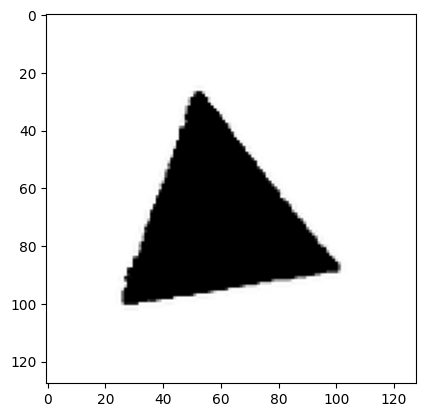

In [39]:
temp = np.moveaxis(img.to('cpu').detach().numpy(), 0, 2)
plt.imshow(temp)

In [56]:
image = Image.open(r"C:\Users\neeraj.saini\Desktop\New folder\DeepD\Triangles-05.png")

In [38]:
temp = np.moveaxis(img.to('cpu').detach().numpy(), 0, 2)

In [63]:
to_tensor = transforms.ToTensor()

# Apply the transformation to convert PIL image to PyTorch tensor
torch_tensor = to_tensor(resized_image)

In [64]:
torch_tensor.shape

torch.Size([3, 128, 128])

In [62]:
resized_image = resize_image(image, img_size)

In [65]:
model(torch_tensor)

c:\Users\neeraj.saini\AppData\Local\anaconda3\envs\py38\lib\site-packages\torch\nn\functional.py:1352: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


tensor([[-1.6436, -0.2148]], grad_fn=<LogSoftmaxBackward0>)